In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Model

In [7]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[55]*N,[55]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

### Testing the context API

In [8]:
with context_inference.pyhf_model(prepared_model):
    post_data = pm.sample(1000, chains = 1, step=pm.Metropolis())
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1000)

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


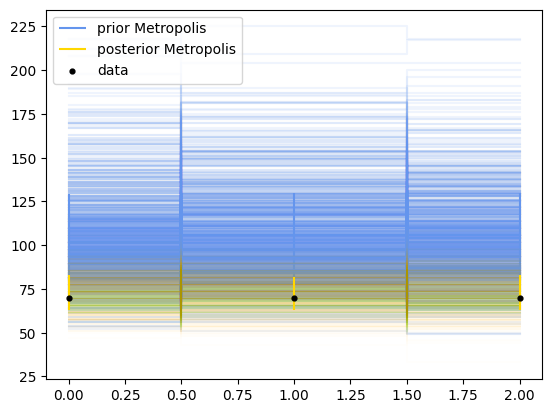

In [9]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.1, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.01, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'gold', label='posterior Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'')

plt.show()

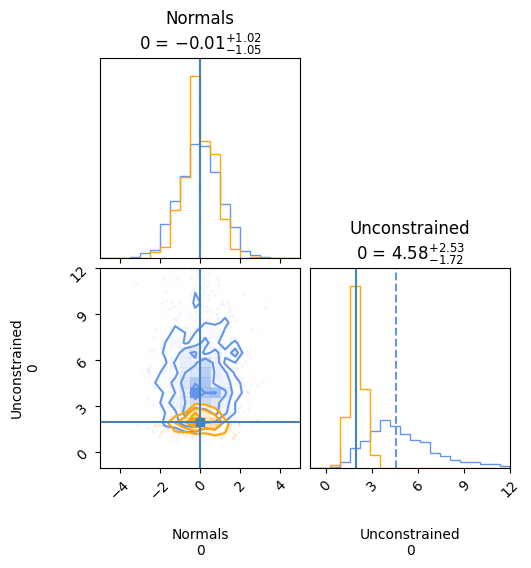

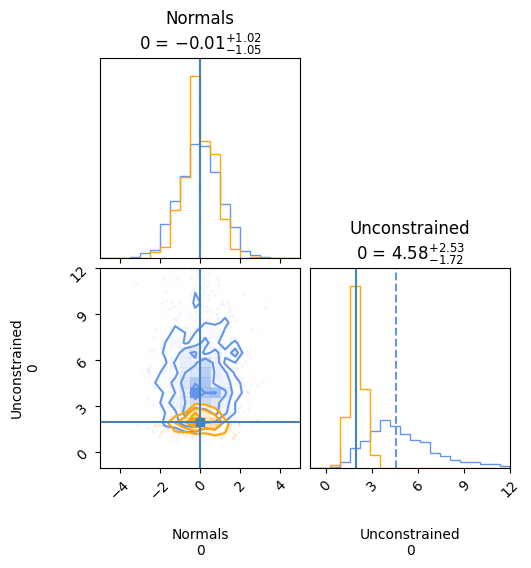

In [18]:
# Parameter Corner Plots
my_range = [(-5, 5), (-1, 12)]
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue', range=my_range)
corner.corner(post_data.posterior, color = 'orange', truths=[0., 2.], fig=a, range=my_range)